In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load dataset, resample to have balanced classes 

In [2]:
complete_data = pd.read_csv('../resources/data/admissions/data.tsv', sep='\t')

# only retain examples with health insurance
complete_data = complete_data[complete_data.HLTHINS != -9]

insured = complete_data[complete_data.HLTHINS != 4].sample(10000)
not_insured = complete_data[complete_data.HLTHINS == 4].sample(10000)

data = pd.concat([insured, not_insured])

In [3]:
data

,CASEID,YEAR,AGE,GENDER,RACE,ETHNIC,MARSTAT,EDUC,EMPLOY,DETNLF,...,BARBFLG,SEDHPFLG,INHFLG,OTCFLG,OTHERFLG,ALCDRUG,DSMCRIT,PSYPROB,HLTHINS,PRIMPAY
123462,123463,1996,6,1,5,5,2,3,1,-9,...,0,1,0,0,0,3,4,-9,1,-9
606358,606359,1996,9,2,4,5,4,3,1,-9,...,0,0,0,0,0,3,-9,-9,3,9
700540,700541,1996,7,2,5,5,2,3,1,-9,...,0,0,0,0,0,3,-9,-9,1,2
533644,533645,1996,9,1,5,5,1,3,4,-9,...,0,0,0,0,0,2,-9,2,2,-9
95891,95892,1996,4,2,5,5,1,3,1,-9,...,0,0,0,0,0,3,-9,2,3,9
698091,698092,1996,7,1,4,5,1,3,1,-9,...,0,0,0,0,0,3,-9,-9,2,4
145537,145538,1996,8,1,5,5,1,5,3,-9,...,0,0,0,0,0,1,-9,1,3,9
1276647,1276648,1996,11,1,5,5,-9,1,4,-9,...,0,0,0,0,0,1,-9,-9,3,-9
320800,320801,1996,5,1,5,5,2,3,1,-9,...,0,0,0,0,0,2,8,2,1,-9
810447,810448,1996,9,2,5,5,2,5,2,-9,...,0,0,0,0,0,1,-9,2,1,2


### Train a logistic regression model, using grid search and k-fold cross-validation

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

def labels_from(df):
    return np.array(df.HLTHINS != 4)

train_data, heldout_data = train_test_split(data, test_size=0.2)
test_data, target_data = train_test_split(heldout_data, test_size=0.5)

y_train = labels_from(train_data)
y_test = labels_from(test_data)
y_target = labels_from(target_data)

categorical_columns = ['AGE', 'GENDER', 'RACE', 'REGION', 'NOPRIOR', 'ALCDRUG', 'PSYPROB', 'SUB2', 'FREQ2', 'VET']
numerical_columns = []

feature_transformation = ColumnTransformer(transformers=[
    ('categorical_features', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ('numerical_features', StandardScaler(), numerical_columns)
])

param_grid = {
    'learner__loss': ['log'],
    'learner__penalty': ['l2', 'l1', 'elasticnet'],
    'learner__alpha': [0.0001, 0.001, 0.01, 0.1]
}

pipeline = Pipeline([
    ('features', feature_transformation), 
    ('learner', SGDClassifier(max_iter=1000))])

search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
model = search.fit(train_data, y_train)

In [12]:
score_on_train_data = accuracy_score(y_train, model.predict(train_data))
score_on_noncorrupted_test_data = accuracy_score(y_test, model.predict(test_data))
score_on_noncorrupted_target_data = accuracy_score(y_target, model.predict(target_data))

print("score on train data: ", score_on_train_data)
print("score on test data: ", score_on_noncorrupted_test_data)
print("score on target data: ", score_on_noncorrupted_target_data)

score on train data:  0.63575
score on test data:  0.636
score on target data:  0.6225


### Introduce errors (missing values) into unseen test data, record resulting class probability entropies and accuracy score as inputs for the meta regressor

In [13]:
def percentiles_of_probas(predictions):
    probs_class_a = np.transpose(predictions)[0]
    probs_class_b = np.transpose(predictions)[1]
    features_a = np.percentile(probs_class_a, np.arange(0,101,5))
    features_b = np.percentile(probs_class_b, np.arange(0,101,5))  
    return np.concatenate((features_a, features_b), axis=0) 

num_features = 42

In [15]:
import random
from scipy.stats import entropy
from tqdm import tqdm

def delete_cells(df, fraction, columns):
    # we operate on a copy of the data
    corrupted_df = df.copy(deep=True)
    
    row_indexes = [row for row in range(corrupted_df.shape[0])]
    # pick random examples
    num_rows_to_pick = int(round(fraction * len(row_indexes)))
    for random_row_index in random.sample(row_indexes, num_rows_to_pick):           
        # delete all specified values in the target columns
        for column in columns:
            column_index = df.columns.get_loc(column)
            corrupted_df.iat[random_row_index, column_index] = -99999#'n/a'
    
    return corrupted_df

generated_training_data = []

for num_columns_affected in tqdm(range(1, 5)):
    for fraction_of_values_to_delete in [0.0, 0.05, 0.25, 0.5, 0.75, 0.99]:    
        for _ in range(0, 100):        
            columns_affected = np.random.choice(categorical_columns, num_columns_affected)        

            corrupted_test_data = delete_cells(test_data, fraction_of_values_to_delete, columns_affected)

            predictions = model.predict_proba(corrupted_test_data)                     
            features = percentiles_of_probas(predictions)
                                       
            score_on_corrupted_test_data = accuracy_score(y_test, model.predict(corrupted_test_data))                
                
            example = np.concatenate((features, [score_on_corrupted_test_data]), axis=0)                                       
            
            generated_training_data.append(example)

100%|██████████| 4/4 [01:01<00:00, 15.49s/it]


### Fit a regression model to the generated training data

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

X = np.array(generated_training_data)[:,:num_features]
y = np.array(generated_training_data)[:,num_features]

param_grid = {
    'learner__n_estimators': np.arange(5,20,5),
    'learner__criterion': ['mae']
}

meta_regressor_pipeline = Pipeline([
    ('scaling', StandardScaler()), 
    ('learner', RandomForestRegressor())
])

meta_regressor = GridSearchCV(meta_regressor_pipeline, param_grid, scoring='neg_mean_absolute_error').fit(X, y)

### Evaluate regression model in predicting effects of errors in the unseen target data

In [17]:
predicted_scores = []
true_scores = []

for num_columns_affected in tqdm(range(1, 5)):
    for fraction_of_values_to_delete in [0.05, 0.25, 0.5, 0.75, 0.99]:    
        for _ in range(0, 100):        
            columns_affected = np.random.choice(categorical_columns, num_columns_affected)        

            corrupted_target_data = delete_cells(target_data, fraction_of_values_to_delete, columns_affected)

            predictions = model.predict_proba(corrupted_target_data)
            features = percentiles_of_probas(predictions)                

            score_on_corrupted_target_data = accuracy_score(y_target, model.predict(corrupted_target_data))
            predicted_score_on_corrupted_target_data = meta_regressor.predict([features])
            
            predicted_scores.append(predicted_score_on_corrupted_target_data)
            true_scores.append(score_on_corrupted_target_data)

100%|██████████| 4/4 [00:57<00:00, 14.33s/it]


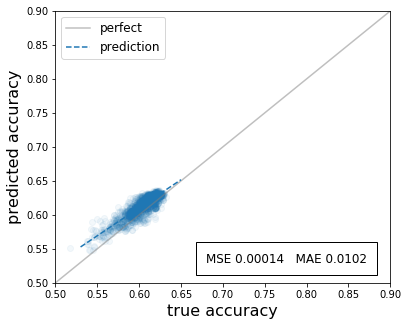

In [20]:
import scipy.stats

plt.plot([0,1], [0, 1], '-', color='grey', alpha=0.5)

gradient, intercept, _, _, _ = scipy.stats.linregress(np.array(true_scores).flatten(), np.array(predicted_scores).flatten())
x1 = np.linspace(0.53, 0.65, 100)
plt.plot(x1, gradient * x1 + intercept, '--')

plt.scatter(true_scores, predicted_scores, alpha=0.05)

plt.xlabel("true accuracy", fontsize=16)
plt.ylabel("predicted accuracy", fontsize=16)

plt.xlim((0.5, 0.9))
plt.ylim((0.5, 0.9))         

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_scores, predicted_scores)
mae = mean_absolute_error(true_scores, predicted_scores)

plt.text(0.68, 0.53, "MSE %.5f   MAE %.4f" % (mse, mae), fontsize=12, 
         bbox=dict(facecolor='none', edgecolor='black', pad=10.0))

plt.legend(['perfect', 'prediction'], fontsize=12)
plt.gcf().set_size_inches(6, 5)
plt.gcf().savefig('figures/adult-lr.pdf', dpi=300)
plt.show()